In [1]:
from coffea import hist
import math

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
plt.style.use(hep.style.CMS)

import awkward as ak

from matplotlib import colors
POPTS={'norm':colors.LogNorm()}

In [2]:
from data import getData, repackage
ldmx_dict = getData(chunks=True, fnames="/Users/chloeg/Desktop/Work/Fermilab2021/DataForHists/kaon_pn_4GeV_May7_ntuple/*.root")

In [3]:
# this is a generic function to extend the aray
def extend_array(arr, new_attr, new_attr_name):
    members={n:arr[n] for n in arr.fields}
    members[new_attr_name] = new_attr
    return ak.zip(members)

# here we are adding the angle (w. respect to the beamline)
def add_angle(arr,br=['px','py','pz','e'],name="theta"):
    from coffea.nanoevents.methods import vector
    ak.behavior.update(vector.behavior)

    part =  ak.zip({"x": arr.px,
                    "y": arr.py,
                    "z": arr.pz,
                    "t": arr.e,
                    },
                    with_name="LorentzVector")
    arr = extend_array(arr, part.theta, name)
    return arr

# this allows us to flatten our array
def flat(x,axis=None): # for now must cast while waiting for coffea to catch up
    try:
        return ak.to_numpy(ak.flatten(x,axis=axis)) 
    except:
        return x

In [4]:
# let's define a couple of histograms
# each .Bin defines a new axis of the histogram

hists = {}
hists["Target_kaon_ke"] = hist.Hist("# of Target SP Kaons", 
                                hist.Cat("Ktype", "Type of Kaons"),      
                                hist.Bin("k", r"Kaon Kinetic Energy [MeV]", 40, 0, 4000),
                                hist.Bin("theta", r"$\theta [^{\circ}]$", 40, 0, 90)
                            )

In [5]:
def ProcessChunk(chunk, hists):
    ldmx_events = repackage(chunk)

    target_kaon = ldmx_events['Target_Kaon']
    
    target_kaon = target_kaon
    target_kaon = add_angle(target_kaon)
    target_kaon_dau1 = ldmx_events['Target_Kaon_dau1']
    target_kaon_dau1 = add_angle(target_kaon_dau1)
    
    masks_id = {'Kshort': 310,
                'Klong': 130,
                'Kpm': 321,
               }
    masses = {'Kshort': 497.648,
              'Klong': 497.648,
              'Kpm': 493.677
             }
    
    for part,pmask in masks_id.items():
        # let's define a pdgID mask
        part_mask = (abs(target_kaon.pdgID)==pmask)
        hists["Target_kaon_ke"].fill(Ktype=part,
                                 k=flat(target_kaon[part_mask].e) - masses[part],
                                 theta=flat(target_kaon[part_mask].theta*(180/math.pi)),
                                )

In [6]:
nchunk = 0
for chunk in ldmx_dict:
    # I usually test my code in one chunck only
    #if nchunk >= 1: break
    nchunk += 1
    print('process',nchunk)
    ProcessChunk(chunk, hists)

process 1
process 2
process 3
process 4
process 5
process 6
process 7
process 8
process 9
process 10
process 11
process 12
process 13
process 14
process 15
process 16
process 17
process 18
process 19
process 20
process 21
process 22
process 23
process 24
process 25
process 26


<Hist (Ktype,k,theta) instance at 0x128cb8550>


Text(0.5, 1.0, '$K_s$')

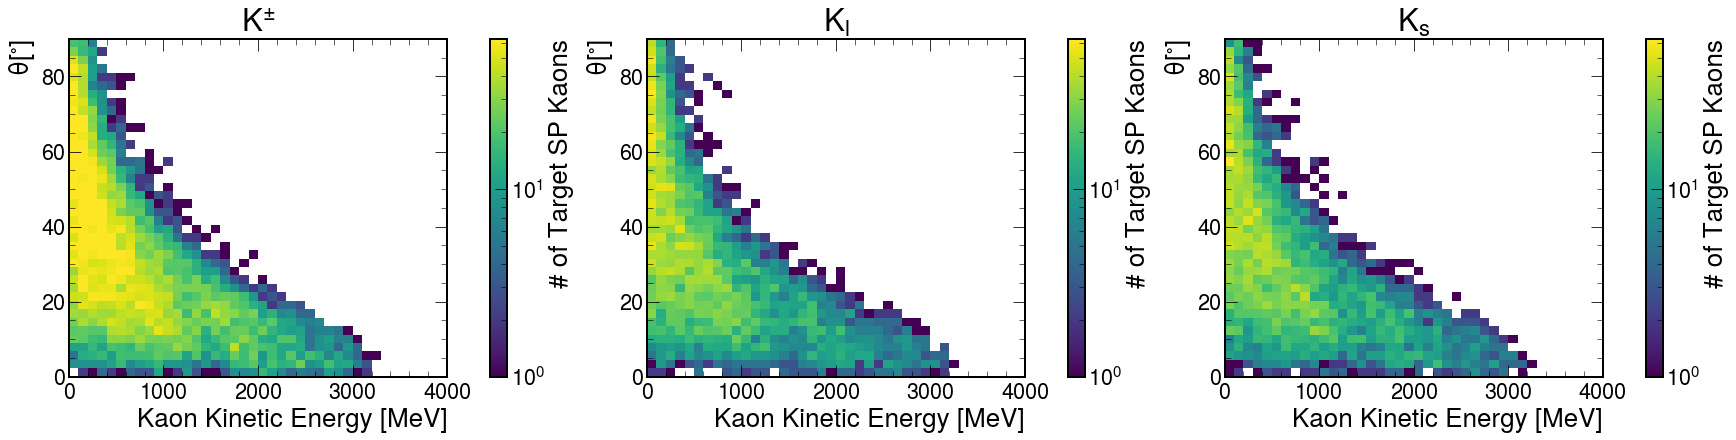

In [10]:
print(hists["Target_kaon_ke"])
fig, ax = plt.subplots(1,3, figsize=(24,6), constrained_layout=True)
hist.plot2d(hists["Target_kaon_ke"].integrate('Ktype', ['Kpm']), xaxis='k', ax=ax[0],patch_opts=POPTS);
ax[0].set_title("$K^{\pm}$")


hist.plot2d(hists["Target_kaon_ke"].integrate('Ktype', ['Klong']), xaxis='k', ax=ax[1],patch_opts=POPTS);
ax[1].set_title("$K_l$")


hist.plot2d(hists["Target_kaon_ke"].integrate('Ktype', ['Kshort']), xaxis='k', ax=ax[2],patch_opts=POPTS);
ax[2].set_title("$K_s$")

#1D plot:
#hist.plot1d(hists["Target_kaon_ke"],ax=ax,clear=False);
#hist.plot1d(hists["Target_kaon_theta"],ax=ax,clear=False);
#leg = ax.legend([r'$K_l$',r'$K^{\pm}$',r'$K_s$', r'$\theta$'])

#Ex:
#hist.plot2d(hists["Target_kaon_electron_cut"].sum('theta','e').integrate('particle','Kshort'),xaxis='kine',ax=ax[0],patch_opts=POPTS);
